In [1]:
import pandas as pd
import data_util
from tqdm.notebook import tqdm
#from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
import numpy as np
from data_util import *
from sklearn_model_hyper import *


import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import scikitplot as skplt

from tensorflow.keras.layers import InputLayer, BatchNormalization, GlobalMaxPool1D, Bidirectional, Dense, Flatten, Conv2D, LeakyReLU, Dropout, LSTM, GRU, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import tensorflow.keras as keras
import random
from catboost import CatBoost
from sklearn.ensemble import RandomForestClassifier



from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score


In [2]:
import pandas as pd
import data_util
from tqdm import tqdm_notebook as tqdm
from data_generator import DataGenerator
from state_util import StateUtil
from tec_an import TecAn
import numpy as np



In [37]:
path = "./data/"
trainX_raw, trainY_raw = load_data("simple_full_", "train", path)
valX_raw, valY_raw = load_data("backtest", "train", path)

trainX_balanced, trainY_balanced = get_balanced_set(trainX_raw, trainY_raw)

X_train, Y_train = trainX_balanced, trainY_balanced

valX, valY = valX_raw, valY_raw

features = trainX_raw.shape[-1]

print("{}".format(trainX_raw.shape))


(4586, 16)


(4586, 16)


In [12]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

params = {
    'random_state' : [42],
    'n_estimators': [10, 30, 500, 1000, 2500],
    #'max_features': [1,4,5,6,7,8, 10, 30, 500],
    'max_depth' : [4,5,6,7,8, 10, 50, 100],
    'criterion' :['gini', 'entropy']
}


clfR = RandomForestClassifier()

clf_grid = gridSearch(X_train, Y_train, clfR, params, make_scorer(accuracy_score))

#5501154734411087

{'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 30, 'random_state': 42}
0.5782909930715935
CPU times: user 58min 15s, sys: 20.6 s, total: 58min 35s
Wall time: 58min 38s


In [13]:
print(clf_grid.best_params_)

{'criterion': 'entropy', 'max_depth': 100, 'n_estimators': 30, 'random_state': 42}


In [27]:

model = make_pipeline(StandardScaler(), RandomForestClassifier(**clf_grid.best_params_))

model.fit(X_train, Y_train)

eval_data(model, X_train, Y_train)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      2165
     class 1       1.00      1.00      1.00      2165

    accuracy                           1.00      4330
   macro avg       1.00      1.00      1.00      4330
weighted avg       1.00      1.00      1.00      4330



In [34]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

#model = clf_grid.best_estimator_

clf = Pipeline([
  ('feature_selection', SelectFromModel(
      LinearSVC()
  )
  ),
  ('classification', RandomForestClassifier())
])

clf.fit(X_train, Y_train)

eval_data(clf, X_train, Y_train)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      2165
     class 1       1.00      1.00      1.00      2165

    accuracy                           1.00      4330
   macro avg       1.00      1.00      1.00      4330
weighted avg       1.00      1.00      1.00      4330



In [16]:
#val_x_norm = normalizer(valX).numpy()

eval_data(model, valX, valY)

#0.4957874270900843

              precision    recall  f1-score   support

     class 0       0.50      0.62      0.55       924
     class 1       0.48      0.36      0.41       901

    accuracy                           0.49      1825
   macro avg       0.49      0.49      0.48      1825
weighted avg       0.49      0.49      0.48      1825



In [18]:
from joblib import dump, load
dump(model, 'model/RandomForestClassifier_accuracy_score') 

['model/RandomForestClassifier_accuracy_score']

In [21]:
valX_raw, valY_raw = load_data("backtest", "train", path)
valX_raw, valY_raw = load_data("", "val", path)

print("{}".format(valX_raw.shape))

eval_data(model, valX_raw, valY_raw)


(459, 16)
              precision    recall  f1-score   support

     class 0       0.50      0.58      0.54       219
     class 1       0.55      0.47      0.50       240

    accuracy                           0.52       459
   macro avg       0.52      0.52      0.52       459
weighted avg       0.52      0.52      0.52       459



In [24]:
import time
import numpy as np

forest = clf_grid.best_estimator_

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.008 seconds


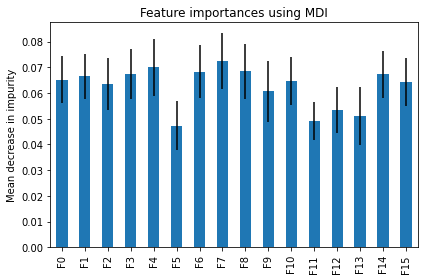

In [26]:
import pandas as pd

feature_names = ['F{}'.format(i) for i in range(features)]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()